<a href="https://colab.research.google.com/github/YuningW/USYD_QBUS6810/blob/main/yuning_forest_model_bank_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification 要求：

1. 
- bank - kaggle competition
    - bank_train: 有target
    - bank_test: 没有target
        
- store
    - 自己进行train_ test_split
    - 自己定义一个loss function
    - model selection and model evaluation

2. 两个数据都要做的：
    - 至少5个模型的预测，至少一个linear model（logistic），至少一个tree- based，
      至少一个model average or model stack
      
    - Data mining：至少三个quantitative的结论，什么样的人对maketing campaign的
      response更 positive
    

In [24]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [25]:
!ls /content/drive/MyDrive/'ColabNotebooks'/Qbus6810/

'assignment 1'			    __pycache__
 bank_dictionary.xlsx		   'QBUS6810 EDA_0517.ipynb'
 bank_sample_submission.csv	   'QBUS6810 EDA.ipynb'
 bank_test.csv			    store.csv
 bank_test.gsheet		    store_dictionary.xlsx
 bank_train.csv			    tutorial4.py
'Classification Project.pdf'	    tutorial9.py
'forest_model_QBUS6810 EDA.ipynb'  'yannis QBUS6810 bank logit_0518.ipynb'


## Import Packages

In [26]:
!pip install phik

In [27]:
!pip install dtreeviz

In [28]:
!pip install shap

In [29]:
!pip install optuna

In [30]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import phik
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

In [31]:
4
!pip install numpy==1.21.5
!pip install scipy==1.7.1
!pip install pandas==1.3.4
!pip install graphviz==0.19.1

In [32]:
import scipy
import sklearn
import graphviz
import dtreeviz
import optuna
import shap

In [33]:
# Methods


# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss

In [34]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 180)

# 1. BANK

## 1.1 Loading data

In [35]:
bank_train = pd.read_csv('/content/drive/My Drive/ColabNotebooks/Qbus6810/bank_train.csv')
bank_test = pd.read_csv('/content/drive/My Drive/ColabNotebooks/Qbus6810/bank_test.csv')

## 1.2 Preliminary Step

In [36]:
bank_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,41,management,married,university.degree,no,no,no,telephone,jul,wed,5,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
1,33,admin.,single,university.degree,no,yes,no,cellular,may,mon,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
2,34,admin.,married,university.degree,no,no,yes,cellular,sep,wed,3,999,0,nonexistent,-1.1,94.199,-37.5,0.886,4963.6,yes
3,48,blue-collar,married,high.school,unknown,no,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
4,32,admin.,married,university.degree,no,yes,no,telephone,may,fri,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [37]:
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26772 entries, 0 to 26771
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             26772 non-null  int64  
 1   job             26772 non-null  object 
 2   marital         26772 non-null  object 
 3   education       26772 non-null  object 
 4   default         26772 non-null  object 
 5   housing         26772 non-null  object 
 6   loan            26772 non-null  object 
 7   contact         26772 non-null  object 
 8   month           26772 non-null  object 
 9   day_of_week     26772 non-null  object 
 10  campaign        26772 non-null  int64  
 11  pdays           26772 non-null  int64  
 12  previous        26772 non-null  int64  
 13  poutcome        26772 non-null  object 
 14  emp.var.rate    26772 non-null  float64
 15  cons.price.idx  26772 non-null  float64
 16  cons.conf.idx   26772 non-null  float64
 17  euribor3m       26772 non-null 

In [38]:
!pip install dabl

     |████████████████████████████████| 558 kB 33.6 MB/s 


In [39]:
# Check types
from dabl import detect_types
bank_train_types = detect_types(bank_train)
bank_train_types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
age,False,False,True,False,False,False,False
job,False,False,False,True,False,False,False
marital,False,False,False,True,False,False,False
education,False,False,False,True,False,False,False
default,False,False,False,True,False,False,False
housing,False,False,False,True,False,False,False
loan,False,False,False,True,False,False,False
contact,False,False,False,True,False,False,False
month,False,False,False,True,False,False,False
day_of_week,False,False,False,True,False,False,False


In [40]:
# Transform 'pdays' from numerical value to categorical value
def pdays_contact(day):
    if 0 <= day < 8:
        return 'contact in 7 days'
    elif 8 <= day < 31:
        return 'contact in 30 days'
    else:
        return 'nerver contact'

In [41]:
# Reassign to 'pdays'
bank_train['pdays'] = bank_train['pdays'].apply(pdays_contact)
bank_train['pdays']

0        nerver contact
1        nerver contact
2        nerver contact
3        nerver contact
4        nerver contact
              ...      
26767    nerver contact
26768    nerver contact
26769    nerver contact
26770    nerver contact
26771    nerver contact
Name: pdays, Length: 26772, dtype: object

In [42]:
# Check types
bank_test_types = detect_types(bank_test)
bank_test_types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
id,False,False,False,False,False,False,True
age,False,False,True,False,False,False,False
job,False,False,False,True,False,False,False
marital,False,False,False,True,False,False,False
education,False,False,False,True,False,False,False
default,False,False,False,True,False,False,False
housing,False,False,False,True,False,False,False
loan,False,False,False,True,False,False,False
contact,False,False,False,True,False,False,False
month,False,False,False,True,False,False,False


## 1.3 Data Understanding

In [43]:
y_bank_train = bank_train['subscribed']

In [44]:
x_bank_train = bank_train.iloc[:, :-1]

In [45]:
x_bank_test = bank_test.iloc[:, 1:]

In [46]:
y_bank_train.shape

(26772,)

In [47]:
x_bank_train.shape

(26772, 19)

In [48]:
x_bank_test.shape

(14416, 19)

In [49]:
cf = x_bank_train.loc[:, bank_train.dtypes == 'object']
cf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26772 entries, 0 to 26771
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job          26772 non-null  object
 1   marital      26772 non-null  object
 2   education    26772 non-null  object
 3   default      26772 non-null  object
 4   housing      26772 non-null  object
 5   loan         26772 non-null  object
 6   contact      26772 non-null  object
 7   month        26772 non-null  object
 8   day_of_week  26772 non-null  object
 9   pdays        26772 non-null  object
 10  poutcome     26772 non-null  object
dtypes: object(11)
memory usage: 2.2+ MB


In [50]:
nf = x_bank_train.loc[:, bank_train.dtypes != 'object']
nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26772 entries, 0 to 26771
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             26772 non-null  int64  
 1   campaign        26772 non-null  int64  
 2   previous        26772 non-null  int64  
 3   emp.var.rate    26772 non-null  float64
 4   cons.price.idx  26772 non-null  float64
 5   cons.conf.idx   26772 non-null  float64
 6   euribor3m       26772 non-null  float64
 7   nr.employed     26772 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 1.6 MB


## 1.4 Understanding the Target Variable

In [51]:
# Check Target
bank_train['subscribed'].value_counts(normalize=True).round(2)

# Imbalanced data, 可以考虑precision/false discovery rate

no     0.89
yes    0.11
Name: subscribed, dtype: float64

In [52]:
# Target transformation of type to int
bank_train_dict = {'yes':1, 'no':0}
bank_train['subscribed'] = bank_train['subscribed'].replace(bank_train_dict)
bank_train['subscribed']

0        0
1        0
2        1
3        0
4        0
        ..
26767    0
26768    0
26769    0
26770    0
26771    0
Name: subscribed, Length: 26772, dtype: int64

In [53]:
bank_yes = bank_train.query('subscribed == 1')
bank_no = bank_train.query('subscribed == 0')

## 1.5 Understanding Numerical Features

In [54]:
bank_train_types[bank_train_types['continuous'] == True]

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
emp.var.rate,True,False,False,False,False,False,False
cons.price.idx,True,False,False,False,False,False,False
cons.conf.idx,True,False,False,False,False,False,False
euribor3m,True,False,False,False,False,False,False
nr.employed,True,False,False,False,False,False,False


In [55]:
bank_train_types[bank_train_types['low_card_int'] == True]

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
age,False,False,True,False,False,False,False
campaign,False,False,True,False,False,False,False
previous,False,False,True,False,False,False,False


In [56]:
# Create a continuous numerical data list
bank_num = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','age', 'campaign', 'previous']

In [57]:
!pip install dataprep

     |████████████████████████████████| 9.5 MB 20.5 MB/s 
     |████████████████████████████████| 749 kB 60.5 MB/s 
     |████████████████████████████████| 943 kB 57.6 MB/s 
     |████████████████████████████████| 366 kB 67.9 MB/s 
     |████████████████████████████████| 95 kB 4.9 MB/s 
     |████████████████████████████████| 1.5 MB 63.6 MB/s 
     |████████████████████████████████| 11.1 MB 52.0 MB/s 
     |████████████████████████████████| 1.1 MB 54.4 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 50.7 MB/s 
     |████████████████████████████████| 133 kB 20.0 MB/s 
     |████████████████████████████████| 965 kB 53.5 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 271 kB 13.5 MB/s 
     |████████████████████████████████| 144 kB 58.2 MB/s 
     |███

In [58]:
#!pip install dask

In [59]:
import sys
# Add folder path to the sys.path list
sys.path.append('/content/drive/My Drive/ColabNotebooks/Qbus6810/') 

In [60]:
corr = bank_train.corr().round(4)
corr

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
age,1.0000,0.0028,0.0221,-0.0014,-0.0023,0.1267,0.0082,-0.0203,0.0323
campaign,0.0028,1.0000,-0.0774,0.1515,0.1243,-0.0118,0.1368,0.1450,-0.0654
previous,0.0221,-0.0774,1.0000,-0.4236,-0.2029,-0.0489,-0.4577,-0.5066,0.2329
emp.var.rate,-0.0014,0.1515,-0.4236,1.0000,0.7755,0.2030,0.9726,0.9068,-0.2977
cons.price.idx,-0.0023,0.1243,-0.2029,0.7755,1.0000,0.0673,0.6891,0.5212,-0.1347
cons.conf.idx,0.1267,-0.0118,-0.0489,0.2030,0.0673,1.0000,0.2841,0.1056,0.0519
euribor3m,0.0082,0.1368,-0.4577,0.9726,0.6891,0.2841,1.0000,0.9448,-0.3074
nr.employed,-0.0203,0.1450,-0.5066,0.9068,0.5212,0.1056,0.9448,1.0000,-0.3550
subscribed,0.0323,-0.0654,0.2329,-0.2977,-0.1347,0.0519,-0.3074,-0.3550,1.0000


## 1.6 Understanding Categorical Features

In [61]:
# Check Categorical variable
bank_train_types[bank_train_types['categorical'] == True]

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
job,False,False,False,True,False,False,False
marital,False,False,False,True,False,False,False
education,False,False,False,True,False,False,False
default,False,False,False,True,False,False,False
housing,False,False,False,True,False,False,False
loan,False,False,False,True,False,False,False
contact,False,False,False,True,False,False,False
month,False,False,False,True,False,False,False
day_of_week,False,False,False,True,False,False,False
poutcome,False,False,False,True,False,False,False


In [62]:
# Check each categorical feature
bank_train['job'].value_counts()

admin.           6826
blue-collar      5979
technician       4337
services         2587
management       1880
retired          1150
entrepreneur      955
self-employed     924
housemaid         707
unemployed        639
student           575
unknown           213
Name: job, dtype: int64

In [63]:
# We can group the level of education
# The reference of education level: https://www.studyaustralia.gov.au/english/study/education-system

# No education - illiterate
# Primary education - basic.4y, basic.6y
# Secondary education - basic.9y
# Senior Secondary education - high.school
# Tertiary education - university.degree, professional.course
# Unkown

education_dict = {'illiterate':'No education',
                 'basic.4y':'Primary education',
                 'basic.6y':'Primary education',
                 'basic.9y':'Secondary education',
                 'high.school':'Senior Secondary education',
                 'university.degree':'Tertiary education',
                 'professional.course':'Tertiary education',
                 'Unkown':'Unkown'}

bank_train['education'] = bank_train['education'].replace(education_dict)
bank_train['education'].value_counts()

Tertiary education            11244
Senior Secondary education     6206
Primary education              4253
Secondary education            3944
unknown                        1110
No education                     15
Name: education, dtype: int64

In [64]:
bank_train['default'].value_counts()

no         21154
unknown     5616
yes            2
Name: default, dtype: int64

In [65]:
bank_train['housing'].value_counts()

yes        14079
no         12053
unknown      640
Name: housing, dtype: int64

In [66]:
bank_train['loan'].value_counts()

no         22089
yes         4043
unknown      640
Name: loan, dtype: int64

In [67]:
bank_train['contact'].value_counts()

cellular     16971
telephone     9801
Name: contact, dtype: int64

In [68]:
bank_train['month'].value_counts()

may    9024
jul    4690
aug    4009
jun    3409
nov    2586
apr    1750
oct     467
sep     369
mar     350
dec     118
Name: month, dtype: int64

In [69]:
bank_train['day_of_week'].value_counts()

thu    5624
mon    5572
tue    5252
wed    5218
fri    5106
Name: day_of_week, dtype: int64

In [70]:
bank_train['poutcome'].value_counts()

nonexistent    23055
failure         2779
success          938
Name: poutcome, dtype: int64

In [71]:
# Build a list for categorical variable
bank_cate = ['pdays','job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

##2 model training

### Ａ. Split train data into train_valid

In [72]:
bank_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,41,management,married,Tertiary education,no,no,no,telephone,jul,wed,5,nerver contact,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
1,33,admin.,single,Tertiary education,no,yes,no,cellular,may,mon,4,nerver contact,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0
2,34,admin.,married,Tertiary education,no,no,yes,cellular,sep,wed,3,nerver contact,0,nonexistent,-1.1,94.199,-37.5,0.886,4963.6,1
3,48,blue-collar,married,Senior Secondary education,unknown,no,no,telephone,may,thu,4,nerver contact,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
4,32,admin.,married,Tertiary education,no,yes,no,telephone,may,fri,3,nerver contact,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [73]:
response = 'subscribed'
predictors = list(bank_cate + bank_num)
index_train, index_valid  = train_test_split(np.array(bank_train.index), stratify=bank_train['subscribed'], 
                                            train_size=0.8, random_state=1)

train = bank_train.loc[index_train,].copy()
valid = bank_train.loc[index_valid,:].copy()

y_train = train['subscribed']
y_valid = valid['subscribed']

### B. More featrue engineering
- one hot encoding or ? ---> use glmm instead?
- target encoding can work really good with categorical data! -- end up with glmm? (the improved target encoding to reduce target leakage)


In [74]:
bank_train.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,41,management,married,Tertiary education,no,no,no,telephone,jul,wed,5,nerver contact,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
1,33,admin.,single,Tertiary education,no,yes,no,cellular,may,mon,4,nerver contact,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0
2,34,admin.,married,Tertiary education,no,no,yes,cellular,sep,wed,3,nerver contact,0,nonexistent,-1.1,94.199,-37.5,0.886,4963.6,1
3,48,blue-collar,married,Senior Secondary education,unknown,no,no,telephone,may,thu,4,nerver contact,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
4,32,admin.,married,Tertiary education,no,yes,no,telephone,may,fri,3,nerver contact,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
5,34,admin.,married,Tertiary education,no,yes,no,cellular,may,mon,1,nerver contact,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,0
6,54,management,divorced,Tertiary education,no,yes,no,cellular,may,wed,2,contact in 30 days,1,success,-1.8,92.893,-46.2,1.334,5099.1,0
7,29,unemployed,single,Primary education,no,no,yes,cellular,jun,wed,3,contact in 7 days,2,success,-2.9,92.963,-40.8,1.244,5076.2,1
8,94,retired,married,Secondary education,no,no,no,cellular,nov,wed,1,nerver contact,1,failure,-3.4,92.649,-30.1,0.716,5017.5,0
9,38,blue-collar,married,Secondary education,unknown,no,no,telephone,jun,mon,1,nerver contact,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,0


In [75]:
train.job.value_counts()

admin.           5422
blue-collar      4875
technician       3467
services         2100
management       1479
retired           896
entrepreneur      747
self-employed     736
housemaid         553
unemployed        512
student           452
unknown           178
Name: job, dtype: int64

In [76]:
print(bank_cate)

['pdays', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [77]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 8.1 MB/s 


In [78]:
from category_encoders import TargetEncoder
from category_encoders.glmm import GLMMEncoder

In [79]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(df, index_train, index_valid, transformation = True):
    data = df.copy()
    #dummy encoding on discrete or categorical variables besides job
    bank_cate_njob_nmon_nday = ['pdays', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
    dummies = []
    labels = bank_cate_njob_nmon_nday
    for label in labels:
        features = pd.get_dummies(data[label],prefix = label,drop_first= True)
        data = data.join(features)
        dummies += list(features.columns)
    
    #YJ transformation on continuous
    transf = bank_num.copy()
    if transformation:
        yj_transf = PowerTransformer(method = 'yeo-johnson',standardize=True).fit(data.loc[index_train,transf])
        data[transf] = yj_transf.transform(data[transf])

    train = data.loc[index_train,].copy()
    valid = data.loc[index_valid,].copy()

    encoder = GLMMEncoder().fit(train[['month']],train['subscribed'])
    train['month_glmm'] = encoder.transform(train[['month']])
    valid['month_glmm'] = encoder.transform(valid[['month']])
    
    encoder = GLMMEncoder().fit(train[['job']],train['subscribed'])
    train['job_glmm'] = encoder.transform(train[['job']])
    valid['job_glmm'] = encoder.transform(valid[['job']])
    
    encoder = GLMMEncoder().fit(train[['day_of_week']],train['subscribed'])
    train['day_glmm'] = encoder.transform(train[['day_of_week']])
    valid['day_glmm'] = encoder.transform(valid[['day_of_week']])
        
    glmm_list = ['job','month','day_of_week']
    glmm_tf = ['month_glmm','job_glmm','day_glmm']

    predictors = bank_num + dummies + glmm_tf

    X_train = train[predictors].copy()
    X_valid = valid[predictors].copy()

    y_train = train['subscribed'].copy()
    y_valid = valid['subscribed'].copy()

    return X_train, X_valid, y_train, y_valid, train, valid , predictors 

X_train, X_valid, y_train, y_valid, train, valid , predictors = feat_engineering(bank_train, index_train, index_valid)

In [80]:
X_train.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'age', 'campaign', 'previous', 'pdays_contact in 7 days',
       'pdays_nerver contact', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Primary education',
       'education_Secondary education', 'education_Senior Secondary education',
       'education_Tertiary education', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'poutcome_nonexistent',
       'poutcome_success', 'month_glmm', 'job_glmm', 'day_glmm'],
      dtype='object')>

In [81]:
X_train.head()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age,campaign,previous,pdays_contact in 7 days,pdays_nerver contact,marital_married,marital_single,marital_unknown,education_Primary education,education_Secondary education,education_Senior Secondary education,education_Tertiary education,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success,month_glmm,job_glmm,day_glmm
7730,0.940941,-0.287905,0.980763,0.812386,0.991007,1.490969,-1.042514,-0.399837,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,-0.795333,0.031674,-0.088733
3031,-1.246384,-1.170647,-1.270658,-1.354974,-1.145177,-1.008826,0.253336,-0.399837,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,-1.280030,-0.584424,0.081396
21793,0.940941,0.556500,-0.429043,0.804646,0.991007,0.692474,1.411831,-0.399837,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-0.968595,-0.479749,0.051630
9944,-0.533615,-0.691309,-0.268539,0.158051,0.240797,-0.049780,-1.042514,-0.399837,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,-0.942401,-0.560519,0.051630
11481,0.940941,0.556500,-0.429043,0.804646,0.991007,1.676664,1.411831,-0.399837,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0.968595,0.866990,0.051630


### C. Decision Tree fitting

####C.1. Use Simple Cost Complexity Pruning for trees 
we use random search to find the better param here
- one with entropy
- one with gini


In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from dtreeviz.trees import *

In [83]:
dt1 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
dt2 = DecisionTreeClassifier(criterion='gini', min_samples_leaf=5)

In [84]:
#for dt1 and dt2
path1 = dt1.cost_complexity_pruning_path(X_train, y_train)
alphas1 = path1.ccp_alphas

path2 = dt2.cost_complexity_pruning_path(X_train, y_train)
alphas2 = path2.ccp_alphas

In [85]:
print(len(alphas1))
print(alphas1[:10])
print(len(alphas2))
print(alphas2[:10])

849
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
737
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [86]:
#make alphas into a df and use graph to present it
#dt1
ccp_df =pd.DataFrame(alphas1)
ccp_df.columns =['alpha1']
impurities1 = path1.impurities
ccp_df['impurity1']=impurities1
##dt2
ccp_df2 = pd.DataFrame(alphas2)
ccp_df2.columns = ['alpha2']
impurities2 = path2.impurities
ccp_df2['imputirty2'] = impurities2

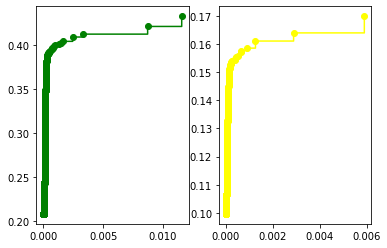

In [87]:
#check impurities and effective alpha
'''
ccp_alphas: also called effective alphas, measures the strenght o flink of a node to the tree.  
Nodes with the smallest effective alpha have the “weakest link” and are pruned first.
'''
fig, ax = plt.subplots(1,2)
ax[0].plot(alphas1[:-1], impurities1[:-1], marker="o", drawstyle="steps-post", label = 'dt1', color='green')
ax[1].plot(alphas2[:-1], impurities2[:-1], marker="o", drawstyle="steps-post", label = 'dt2', color='yellow')

#we should use gini with the lower total impurity of leaves data shown as below! 

In [88]:
#now run grid search to find best alpha?
from sklearn.model_selection import RandomizedSearchCV
search_space = {
    'ccp_alpha': alphas1,
}
tree_search1 = RandomizedSearchCV(dt1, search_space, cv = 5 , scoring='neg_log_loss')
tree_search1.fit(X_train, y_train)
tree1 = tree_search1.best_estimator_

print('Best parameters found by random search:', tree_search1.best_params_, '\n')

Best parameters found by random search: {'ccp_alpha': 0.001510491900866287} 



In [89]:
#now run grid search to find best alpha
from sklearn.model_selection import RandomizedSearchCV
search_space = {
    'ccp_alpha': alphas2,
}
tree_search2 = RandomizedSearchCV(dt2, search_space, cv = 5 , scoring='neg_log_loss')
tree_search2.fit(X_train, y_train)
tree2 = tree_search2.best_estimator_

print('Best parameters found by random search:', tree_search2.best_params_, '\n')

Best parameters found by random search: {'ccp_alpha': 5.212809600863363e-05} 



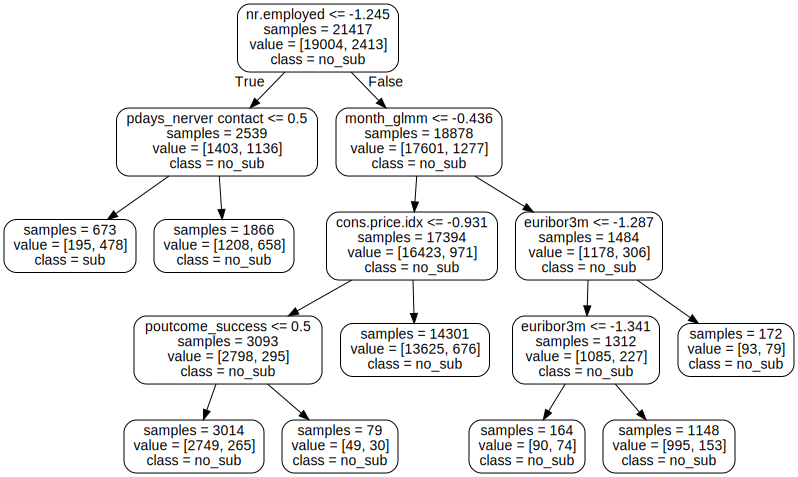

In [90]:
#final tree for dt1
tree_graph1 = export_graphviz(tree1, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['no_sub','sub'], rounded=True) 
graph = graphviz.Source(tree_graph1)
graph.render('tree01') # saves tree to a file
graph

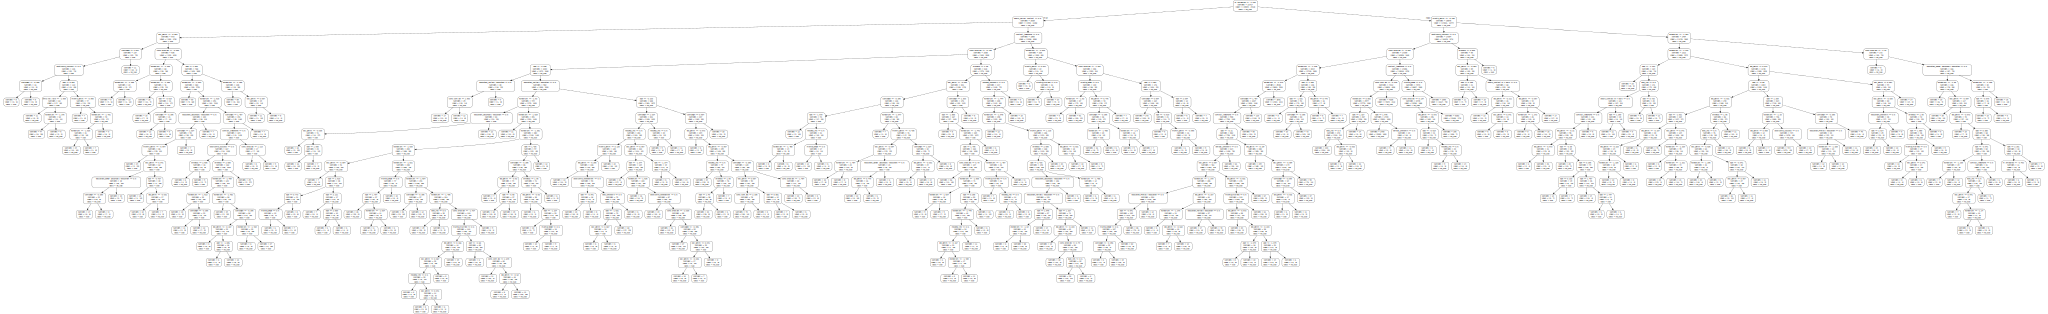

In [91]:
#final tree for dt2
tree_graph2 = export_graphviz(tree2, out_file=None , impurity=False, feature_names = predictors,
                           class_names=['no_sub','sub'], rounded=True) 
graph = graphviz.Source(tree_graph2)
graph.render('tree02') # saves tree to a file
graph

In [92]:
#now we have to refit the two decision tree
tree1.fit(X_train,y_train)
tree2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=5.212809600863363e-05, min_samples_leaf=5)

### D.Random Forest
- hyperparameter tuning
- final random tree

#### D.1. Simple random forest

In [93]:
#simple random forest (without hyperparameter tuning)
from sklearn.ensemble import RandomForestClassifier

rf1 =  RandomForestClassifier(n_estimators=300,  criterion='entropy',max_features = 'auto', min_samples_leaf= 6)
rf1.fit(X_train, y_train)

rf2 = RandomForestClassifier(n_estimators=300,  criterion='gini',max_features = 'auto', min_samples_leaf= 6)
rf2.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=6, n_estimators=300)

To get the best random forest model or any model, hyperparameter tuning is a crucial part during training. Utilize Optuna for better speed and reduction of computational cost.

#### D.2 hyperparameter tuning

**!! check more documentation on loss funtion defining part!! Make sure to get the best scoring method and loss funtion**

In [94]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    
    model = RandomForestClassifier(n_estimators = 300,  
                                  criterion = criterion,  
                                  max_features = max_features, 
                                  min_samples_leaf= min_samples_leaf,
                                  random_state = 1)
    
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
    loss = 1 - np.mean(scores)
    
    return loss

sampler = TPESampler(seed=1) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(rf_objective, n_trials = 350, timeout = 240) 

# the timeout should be as high as possible in a real application

[I 2022-05-21 03:10:40,348] A new study created in memory with name: no-name-f8a6b912-74b4-4da1-8973-f5747ca1a6a6
[I 2022-05-21 03:11:12,169] Trial 0 finished with value: 0.10496359023023949 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 7}. Best is trial 0 with value: 0.10496359023023949.
[I 2022-05-21 03:11:44,774] Trial 1 finished with value: 0.09940727166421082 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 4, 'max_features': 7}. Best is trial 1 with value: 0.09940727166421082.
[I 2022-05-21 03:12:21,569] Trial 2 finished with value: 0.09880036223377198 and parameters: {'criterion': 'gini', 'min_samples_leaf': 9, 'max_features': 14}. Best is trial 2 with value: 0.09880036223377198.
[I 2022-05-21 03:13:08,009] Trial 3 finished with value: 0.10585079700803968 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 14}. Best is trial 2 with value: 0.09880036223377198.
[I 2022-05-21 03:13:24,884] Trial 4 finished with val

In [95]:
#bset param
params_rf = study.best_params
params_rf


{'criterion': 'entropy', 'max_features': 7, 'min_samples_leaf': 14}

In [96]:
#train with best param
rf_v1 = RandomForestClassifier(n_estimators=2500, **params_rf) #Bootstrapping 2500 data sets
rf_v1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=7, min_samples_leaf=14,
                       n_estimators=2500)

### Add boosting model to improve our ml model
- gradientboosting
- xgboosting
- lightgbm boosting
  - for lgbm we use the original LightGBM first, then, we use the best param that we get from lightgbm and apply it to the sklearn api's version. In this way, we can get the predict_proba function that sklearn provide for a better evaluation

In [97]:
# tutorial 09 package
import sys
# Add the parent folder path to the sys.path list
sys.path.append('/Packages')
from tutorial9 import plot_feature_importance

In [98]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 8, n_estimators= 1000, subsample = 0.45)
gb.fit(X_train, y_train)

CPU times: user 36.4 s, sys: 48.4 ms, total: 36.5 s
Wall time: 38.9 s


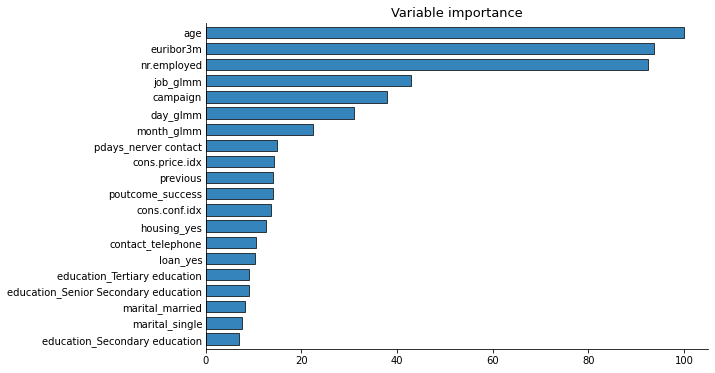

In [99]:
plot_feature_importance(gb, labels=predictors)
plt.show()

In [100]:
%%time

import xgboost as xgb

xgbst = xgb.XGBClassifier(objective='binary:logistic', booster = 'gbtree', learning_rate = 0.02, 
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0)

# n_estimators: number of trees
# subsample: fraction of observations used to fit each tree
# reg_lambda: L2 regularisation penalty
# reg_alpha: L1 regularisation penalty
# colsample_bytree: fraction of features considered for each tree (alternatives: bylevel, bynode)
# min_child_weight: approximately equal to the minimum number of samples in each node

xgbst.fit(X_train, y_train)

CPU times: user 1min 10s, sys: 365 ms, total: 1min 10s
Wall time: 1min 10s


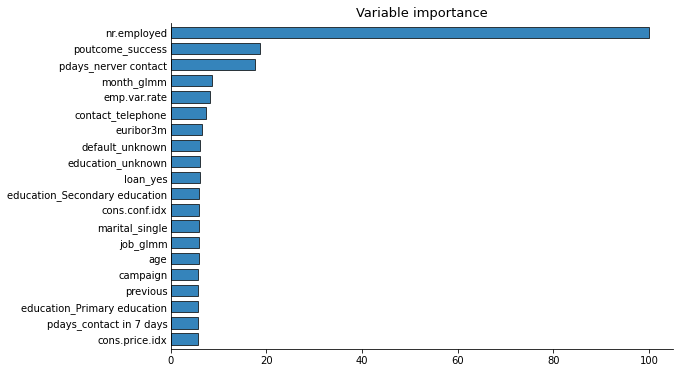

In [101]:
plot_feature_importance(xgbst, labels=predictors)
plt.show()

In [104]:
#lightgbm sklearn api version here (here's the basic model version)
%%time
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(objective='binary', boosting_type = 'gbdt', 
                         n_estimators =2000, learning_rate = 0.01,  
                         num_leaves = 24,
                         lambda_l1 = 0.0, lambda_l2 = 0.0,
                         bagging_fraction = 0.6, bagging_freq = 1, 
                         feature_fraction = 1.0, min_data_in_leaf = 3)
# gbdt: gradient boosted decision trees
# n_estimators: number of iterations
# bagging_fraction: fraction of observations used to fit each tree
# feature_fraction: fraction of features considered for each tree

lgbm1 = lgbm.fit(X_train, y_train)

## Binary Classification:
## lgb.train({"objective": "binary", 

## MultiClass Classification:
##  lgb.train({"objective": "multiclass", "num_class":??,

CPU times: user 6.25 s, sys: 140 ms, total: 6.39 s
Wall time: 6.47 s


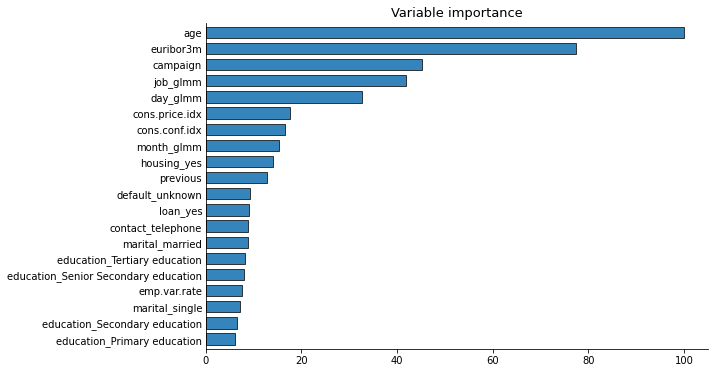

In [105]:
plot_feature_importance(lgbm, labels=predictors)
plt.show()

In [106]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [107]:
#basic catboost
%%time

from catboost import CatBoostClassifier
cb = CatBoostClassifier(loss_function='CrossEntropy', verbose=0)        
cb.fit(X_train, y_train)

CPU times: user 10.6 s, sys: 594 ms, total: 11.2 s
Wall time: 6.17 s


### let's first utilize lgbm's full function! 

In [109]:
import lightgbm as lgb

In [111]:
# We have to reconstruct the dataset to tune min_data_in_leaf
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

from optuna.samplers import TPESampler

def lgbm_objective(trial):
    
    params_lgb = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1,
     }
    
    # Cross-validation 
    history = lgb.cv(params_lgb, train_data, num_boost_round = 7500, 
                 nfold = 5, stratified = False, early_stopping_rounds = 80, verbose_eval=0)
    
    # Save full set of parameters
    trial.set_user_attr('params', params_lgb)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['binary_logloss-mean']))
    
    return history['binary_logloss-mean'][-1] # returns CV error for the best trial

study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=1))
study.optimize(lgbm_objective, n_trials=1500, timeout = 240)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2022-05-21 03:20:48,954] A new study created in memory with name: no-name-fa4c680f-0f7a-4288-acc2-3705bbaa0bc0
[I 2022-05-21 03:21:09,957] Trial 0 finished with value: 0.2718103376331876 and parameters: {'num_leaves': 28, 'lambda_l1': 0.030403280126677572, 'lambda_l2': 1.002373030936316e-08, 'bagging_fraction': 0.6511662863159199, 'bagging_freq': 2, 'feature_fraction': 0.5461692973843989, 'min_data_in_leaf': 24}. Best is trial 0 with value: 0.2718103376331876.
[I 2022-05-21 03:21:25,920] Trial 1 finished with value: 0.2722572350810538 and parameters: {'num_leaves': 23, 'lambda_l1': 3.72312200494449e-05, 'lambda_l2': 0.0007068879948063832, 'bagging_fraction': 0.7095972572016473, 'bagging_freq': 7, 'feature_fraction': 0.6022261248657588, 'min_data_in_leaf': 113}. Best is trial 0 with value: 0.2718103376331876.
[I 2022-05-21 03:22:04,613] Trial 2 finished with value: 0.2728167092863024 and parameters: {'num_leaves': 3, 'lambda_l1': 0.010819509974097813, 'lambda_l2': 5.6982725955953586e

In [112]:
params_lgbm = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params_lgbm

Number of boosting iterations: 386 

Best parameters:


{'bagging_fraction': 0.8959906073587441,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7467564402310316,
 'feature_pre_filter': False,
 'lambda_l1': 1.9071941215938054e-07,
 'lambda_l2': 0.01514718286733572,
 'learning_rate': 0.01,
 'min_data_in_leaf': 18,
 'num_leaves': 31,
 'objective': 'binary',
 'verbosity': -1}

In [113]:
importance = optuna.importance.get_param_importances(study)

importance

OrderedDict([('min_data_in_leaf', 0.6178369950577232),
             ('num_leaves', 0.22830783195839008),
             ('bagging_fraction', 0.0876018521814208),
             ('feature_fraction', 0.0466272541551151),
             ('bagging_freq', 0.018010835855802317),
             ('lambda_l1', 0.0009577942858821759),
             ('lambda_l2', 0.0006574365056663502)])

the following is lgb from sklearn api , because we need the predic proba to check the model which lgb did not have

In [114]:
#final model lgbm_sklearnapi
#since lgb original don't produce predict prob, We'll use the sklearn api version to compare
params = {
 'objective': 'binary',
 'bagging_fraction': 0.8959906073587441,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7467564402310316,
 'feature_pre_filter': False,
 'lambda_l1': 1.9071941215938054e-07,
 'lambda_l2': 0.01514718286733572,
 'learning_rate': 0.01,
 'min_data_in_leaf': 18,
 'num_leaves': 31,
 'objective': 'binary',
 'verbosity': -1}
lgbm_opt = lgb.LGBMClassifier(n_estimators=2000,**params)
lgbm_opt = lgbm_opt.fit(X_train, y_train) 

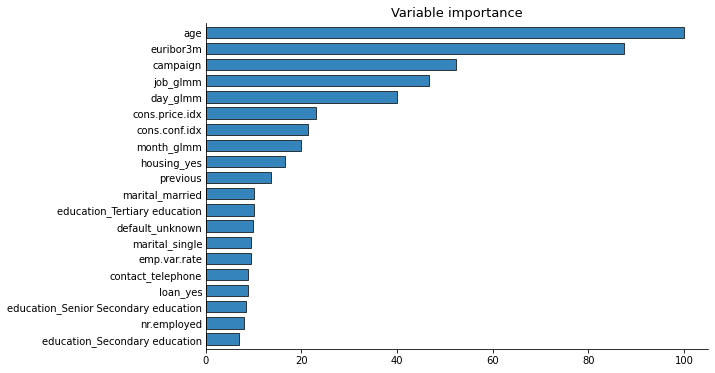

In [115]:
plot_feature_importance(lgbm_opt, labels=predictors)
plt.show()

### evaluation

In [116]:
#base model here
#for group project we use yannis's logit
#this is just for demonstration purpose
from sklearn.linear_model import LogisticRegressionCV 
logit = LogisticRegressionCV()
logit.fit(X_train, y_train)

LogisticRegressionCV()

In [117]:
#check which one perform the best
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic', 'Decision Tree1','Decision Tree2','Random forests basic1',
      'Random forest basic2','Random forests_opt',
      'gradient boosting','catboost','xgboosting','lightgbm','lightgbm_opt']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree1,tree2,rf1,rf2, rf_v1, gb, cb, xgbst, lgbm1, lgbm_opt]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
      y_prob[:, i] = method.predict_proba(X_valid)[:, 1]
      y_pred = method.predict(X_valid)

      tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

      results.iloc[i,0] =  1 - accuracy_score(y_valid, y_pred)
      results.iloc[i,1] =  tp/(tp+fn)
      results.iloc[i,2] =  tn/(tn+fp)
      results.iloc[i,3] =  precision_score(y_valid, y_pred)
      results.iloc[i,4] =  roc_auc_score(y_valid, y_prob[:,i])
      results.iloc[i,5] =  log_loss(y_valid, y_prob[:,i])

results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.103,0.222,0.982,0.615,0.798,0.281
Decision Tree1,0.103,0.189,0.987,0.655,0.785,0.278
Decision Tree2,0.112,0.285,0.965,0.507,0.773,0.530
Random forests basic1,0.101,0.254,0.981,0.632,0.807,0.272
Random forest basic2,0.100,0.255,0.982,0.642,0.806,0.272
Random forests_opt,0.101,0.239,0.983,0.640,0.809,0.271
gradient boosting,0.107,0.279,0.971,0.553,0.800,0.282
catboost,0.104,0.272,0.975,0.577,0.811,0.276
xgboosting,0.107,0.292,0.969,0.547,0.787,0.295
lightgbm,0.101,0.292,0.976,0.609,0.809,0.273


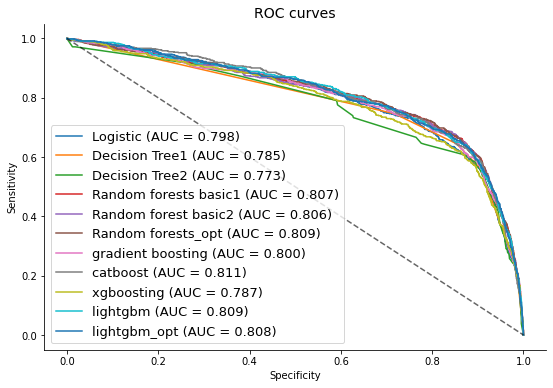

In [118]:
from tutorial9 import plot_roc_curves

fig, ax = plot_roc_curves(y_valid, y_prob, labels=pd.Series(rows))
plt.show()

#### result 

In [ ]:
bank_test_copy = bank_test.copy()

In [ ]:

def feat_engineering_test(df_train, df_test, index_train, index_valid, transformation = True):
    data_tr = df_train.copy()
    data_te = df_test.copy()

    #the data engineering at the beginning
    data_te['pdays'] = data_te['pdays'].apply(pdays_contact)
    # the part for changing education data
    data_te['education'] = data_te['education'].replace(education_dict)

    #dummy encoding on discrete or categorical variables besides job
    bank_cate_njob_nmon_nday = ['pdays', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
    dummies = []
    labels = bank_cate_njob_nmon_nday
    for label in labels:
        features = pd.get_dummies(data_te[label],prefix = label,drop_first= True)
        data_te = data_te.join(features)
        dummies += list(features.columns)
    
    #YJ transformation on continuous
    transf = bank_cont.copy()
    if transformation:
        yj_transf = PowerTransformer(method = 'yeo-johnson',standardize=True).fit(data_tr.loc[index_train,transf])
        data_te[transf] = yj_transf.transform(data_te[transf])

    train = data_tr.loc[index_train,].copy()
    valid = data_tr.loc[index_valid,].copy()

    encoder = GLMMEncoder().fit(train[['month']],train['subscribed'])
    data_te['month_glmm'] = encoder.transform(data_te[['month']])
    
    encoder = GLMMEncoder().fit(train[['job']],train['subscribed'])
    data_te['job_glmm'] = encoder.transform(data_te[['job']])
    
    encoder = GLMMEncoder().fit(train[['day_of_week']],train['subscribed'])
    data_te['day_glmm'] = encoder.transform(data_te[['day_of_week']])
 
        
    glmm_list = ['job','month','day_of_week']
    glmm_tf = ['month_glmm','job_glmm','day_glmm']

    predictors_te = bank_cont + dummies + glmm_tf
    data_te = data_te[predictors_te]
    return data_te, predictors_te

data_te,predictors_te = feat_engineering_test(bank_train, bank_test_copy, index_train, index_valid)

In [ ]:
data_te.info()

In [ ]:
X_train.info()

In [ ]:
rf_version1 = rf_v1.predict(data_te)

In [ ]:
logit_v1 = logit.predict(data_te)

In [ ]:
lgb_skl = skl_lgb.predict(data_te)

In [ ]:
cat_b = cb.predict(data_te)

In [ ]:
predictions_rf_v1 = pd.DataFrame(rf_version1,columns=['subscribed']).to_csv('/content/drive/My Drive/ColabNotebooks/Qbus6810/assignment 1/0519_prediction_forsub1.csv')

In [ ]:
predictions_logit = pd.DataFrame(logit_v1,columns=['subscribed']).to_csv('/content/drive/My Drive/ColabNotebooks/Qbus6810/assignment 1/0519_prediction_forsub2.csv')

In [ ]:
predictions_light_gbm = pd.DataFrame(lgb_skl,columns=['subscribed']).to_csv('/content/drive/My Drive/ColabNotebooks/Qbus6810/assignment 1/0519_prediction_forsub3.csv')

In [ ]:
predictions_cat = pd.DataFrame(cat_b,columns=['subscribed']).to_csv('/content/drive/My Drive/ColabNotebooks/Qbus6810/assignment 1/0519_prediction_forsub4.csv')

### **Interpretation**
- while single tree is easy to interpret with all the features written in on the tree, random forest isn't that easy to interpret. 
- We can utlize shap to interpret the result (both locally for specific observation as well as globally for the whole model)

In [2]:
%%time 

shap.initjs()
explainer = shap.Explainer(rf_v1)
shap_values = explainer.shap_values(X_valid.iloc[:1000, :])

# SHAP needs background data to compute SHAP values
# We use only part of the validation set to save time

NameError: ignored

some global explaination for our random forest

In [3]:
shap_values = explainer.shap_values(X_valid.iloc[:1000, :])
shap.summary_plot(shap_values[1], X_valid.iloc[:1000, :])

NameError: ignored

In [ ]:
# use barplot to easily identified the most important feature and later we can retrain our data with these features
shap.summary_plot(shap_values[1], X_valid.iloc[:1000, :], plot_type = 'bar')

In [ ]:
#use a standard way of plotting feature importance through tutorial9 's ploting package
from tutorial9 import plot_feature_importance
plot_feature_importance(rf_v1, predictors)
plt.show()

### SKIP FIRST !!! OR else need to refit shap for 20 minutes!!! --- following is just some local explaination demonstration

In [ ]:
X_valid.head()

In [ ]:
x_01_df = x_01.T
x_01_df.columns = ['valid. observation 16600']
x_01_df['SHAP values'] = np.round(np.squeeze(shap_values[1]),6)
print(x_01_df)
print('\n  predicted P(Subscribed | validation observation 16600 )  = \n', explainer.expected_value[1])

In [ ]:
#local explaination on the first observation
shap.initjs()
x_01 = X_valid.iloc[[0],:]
shap_values = explainer.shap_values(x_01)
shap.force_plot(explainer.expected_value[1], shap_values[1], feature_names = predictors)

# explainer.expected_value[1] gives the base values for the class with index one (left the company)
# Similarly, shap_values[1] gives the SHAP values for the class with index one (left the company)

In [ ]:
#waterfall 
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0, :], feature_names = predictors)